# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

In [3]:
import os
files = os.listdir("test_images/")
filelist = []
for file in files:
    filelist.append(os.path.join("test_images/", file))

## Lane Finding Pipeline


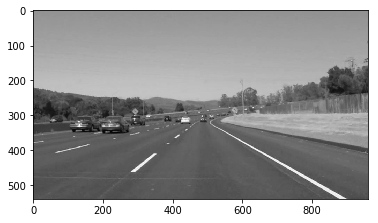

Height:  540  Width:  960


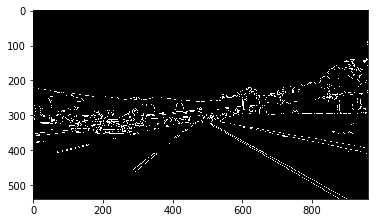

Vertices:  [[384 302]
 [144 540]
 [912 540]
 [576 302]]


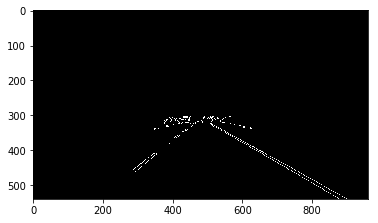

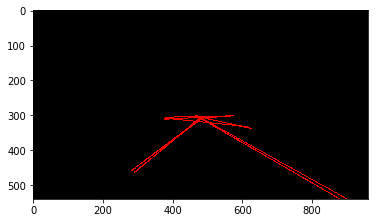

new left line:  [413, 361, 184, 540]
new right line:  [887, 540, 572, 361]


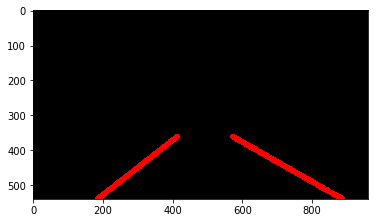

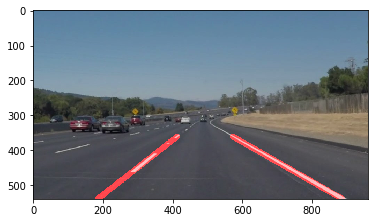

In [13]:
# Function to identify left and right lanes
def identify_left_right_lanes(lines):
    right_line = []
    left_line = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > math.sin(np.pi/6) and slope < math.sin(np.pi/3):
                right_line.append([slope, x1, y1, x2, y2])
            elif slope < math.cos(2*np.pi/3) and slope > math.cos(5*np.pi/6):
                left_line.append([slope, x1, y1, x2, y2])
    return left_line, right_line

# Function to get new x coordinates given y coordinates and line list
def get_xcoordinate(y1_coordinate, y2_coordinate, line):
    x1_coordinate = 0
    x2_coordinate = 0
    x1_list = []
    x2_list = []
    if (len(line) > 0):
        for pt in line:
            x1_list.append(((y1_coordinate - pt[2])/pt[0]) + pt[1])
            x2_list.append(((y2_coordinate - pt[2])/pt[0]) + pt[1])
        x1_coordinate = int(sum(x1_list)/len(x1_list))
        x2_coordinate = int(sum(x2_list)/len(x2_list))
    return x1_coordinate, x2_coordinate

# def get_curve_pts(line, x1, x2, width):
#     X = np.array([])
#     y = np.array([])
#     C = np.array([])
# #     curve = np.array([], dtype=np.int32)
#     for pt in line:
#         X = np.append(X, [pt[1], pt[3]])
#         y = np.append(y, [-pt[2], -pt[4]])
# #         curve = np.append(curve, [pt[1], pt[2], pt[3], pt[4]])
# #     X = X.reshape(-1,1)
# #     y = y.reshape(-1,1)
#     z = np.polyfit(X, y, 3)
#     print (z)
#     x_pred = np.linspace(x1, x2, 10)
#     y_pred = np.array([])
#     for i in range(x_pred.shape[0]):
#         y_pred = np.append(y_pred, np.polyval(z, x_pred[i]))
#     plt.plot(x_pred, y_pred, 'b', lw=3)
#     plt.show()
#     curve = np.array([x_pred, y_pred], dtype=np.int32)
#     curve = curve.reshape(-1, 1)
# #     C = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(X), X)), np.transpose(X)), y)
# #     p1 = [C[2,0], C[1,0], C[0,0]-y1]
# #     p2 = [C[2,0], C[1,0], C[0,0]-y2]
# # #     print ('P1: ', p1, 'P2: ', p2)
# #     R1 = np.roots(p1)
# #     R2 = np.roots(p2)
# # #     print ('R1: ', R1, 'R2: ', R2)
# #     r1 = R1.real[abs(R1.imag)<1e-5]
# #     for i in range(len(r1)):
# #         if isLeft:
# #             if r1[i] > 0 and r1[i] < width/2:
# #                 curve = np.append(curve, [int(r1[i]), y1])
# #         else:
# #             if r1[i] < width and r1[i] > width/2:
# #                 curve = np.append(curve, [int(r1[i]), y1])
# #     r2 = R2.real[abs(R2.imag) < 1e-5]
# #     for i in range(len(r2)):
# #         if isLeft:
# #             if r2[i] > 0 and r2[i] < width/2:
# #                 curve = np.append(curve, [int(r2[i]), y2])
# #         else:
# #             if r2[i] < width and r2[i] > width/2:
# #                 curve = np.append(curve, [int(r2[i]), y2])
# #     curve = curve.reshape(-1,2)
# #     curve = curve[curve[:,1].argsort()]
# # #     print ('Curve pts: ', curve)
#     print ('Curve shape: ', curve.shape)
#     return curve


def lane_detection(image, display_images = 0, write_images = 0):    
    # grayscale conversion
    gray = grayscale(image)
    height, width = image.shape[0], image.shape[1]
    if display_images > 0:
        plt.imshow(gray, cmap='gray')
        plt.show()
        print ('Height: ', height, ' Width: ', width)
    if write_images > 0:
        cv2.imwrite('test_images_output/gray.jpg', gray)

    # Gaussian filter
#     kSize = 3
#     blur_img = gaussian_blur(gray, kSize)
#     if display_images > 0:
#         plt.imshow(blur_img, cmap='gray')
#         plt.show()
#     if write_images > 0:
#         cv2.imwrite('test_images_output/blurred.jpg', blur_img)

    #edge detection
    low_threshold = 50
    high_threshold = 150
    edge = canny(gray, low_threshold, high_threshold)
    if display_images > 0:
        plt.imshow(edge, cmap='gray')
        plt.show()
    if write_images > 0:
        cv2.imwrite('test_images_output/canny_edge.jpg', edge)

    # ROI Selection
    a = [width*0.4, height*0.56]
    b = [width*0.15, height]
    c = [width*0.95, height]
    d = [width*0.6, height*0.56]
    vertices = np.array([a, b, c, d], dtype=np.int32)
    roi_img = region_of_interest(edge, vertices)
    if display_images > 0:
        print ('Vertices: ', vertices)
        plt.imshow(roi_img, cmap='gray')
        plt.show()
    if write_images > 0:
        cv2.imwrite('test_images_output/roi_image.jpg', roi_img)

    # Hough lines
    rho = 1
    theta = np.pi/180.
    threshold = 50
    min_line_len = 130
    max_line_gap = 150
    line_img, lines = hough_lines(roi_img, rho, theta, threshold, min_line_len, max_line_gap)
    if display_images > 0:
        plt.imshow(line_img, cmap='gray')
        plt.show()
    if write_images > 0:
        plt.imsave('test_images_output/hough_lines.jpg', line_img)
    
    # Identify right and left lane
    left_line, right_line = identify_left_right_lanes(lines)
    

    # Obtain new set of x and y coordinates to draw the lines
    new_line = []
    
    # get new left line
    new_y1 = int(0.67*height)
    new_y2 = height
    new_x1, new_x2 = get_xcoordinate(new_y1, new_y2, left_line)
    
#     left_curve = get_curve_pts(left_line, width*0.15, width*0.4, width)
#     new_lcurve_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
#     cv2.polylines(new_lcurve_img, left_curve, False, (0,0,255), 15)
# #     plt.imshow(new_lcurve_img)
# #     plt.show()
    
    if display_images > 0:
        print ('new left line: ',[new_x1, new_y1, new_x2, new_y2])
        
    # append new left line
    if (new_x1 > 0 and new_x2 > 0):
        new_line.append([new_x1, new_y1, new_x2, new_y2])
        
    # get new right line
    new_y1 = height
    new_y2 = int(0.67*height)
    new_x1, new_x2 = get_xcoordinate(new_y1, new_y2, right_line)
    
#     right_curve = get_curve_pts(right_line, width*0.6, width*0.95, width)
#     new_rcurve_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
#     cv2.polylines(new_rcurve_img, [right_curve], False, (0,0,255), 15)
# #     plt.imshow(new_rcurve_img)
# #     plt.show()
    
#     combined = cv2.bitwise_or(new_lcurve_img, new_rcurve_img)
# #     plt.imshow(combined)
# #     plt.show()
    
    if display_images > 0:
        print ('new right line: ',[new_x1, new_y1, new_x2, new_y2])
        
    # append new right line
    if (new_x1 > 0 and new_x2 > 0):
        new_line.append([new_x1, new_y1, new_x2, new_y2])
    
    # draw new lines and get the line image
    new_line_np = np.asarray([new_line], dtype=np.int32)
    new_line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(new_line_img, [new_line], thickness=15)
    if display_images > 0:
        plt.imshow(new_line_img)
        plt.show()
    if write_images > 0:
        plt.imsave('test_images_output/new_line.jpg', new_line_img)
        
    # Superimpose the line image onto the original image
    out = weighted_img(new_line_img, image)
    if display_images > 0:
        plt.imshow(out)
        plt.show()
    if write_images > 0:
        plt.imsave('test_images_output/final.jpg', out)
        
#     out = weighted_img(combined, image)
#     out = image
    
    return out

# run the pipeline on test images
for i, imgFile in enumerate(filelist):
    image = mpimg.imread(imgFile)
    # save intermediate stage output for first image and run just the pipeline for next all
    if i == 0:
        im_out = lane_detection(image, 1)
    else:
        im_out = lane_detection(image)
    # save the output files for all the test images
    output_file = os.path.join('test_images_output/', files[i],)
    plt.imsave(output_file, im_out)

## Test on Videos

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(image):
    result = lane_detection(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [16]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 221/222 [00:04<00:00, 47.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 5.41 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [18]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 681/682 [00:17<00:00, 38.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 18.7 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [20]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:14<00:00, 17.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 16.4 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))